In [1]:
#Biblioteket
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Enklar deklaratioer av konstanter
mu = 3        #Friktionskoffecient 2=<mu<=4, vi valde medelvärdet
g = 9.82      #(m/s^2) tyngdfaktor

Cd = 0.3      #luftmotståndskoeffecient ENHETSLÖS!
Af = 1.63     #(m^2) frontarea
p_air = 1.2   #(kg/m^3)   luftdensitet 

C_rr = 0.03   #rullmotståndskoffecient 

In [3]:
#Implementering av ekvationerna som vi har från In 2 del (TEKNISKA KRAV)       
def F_aero(Hast):  #(N) Luftmotstånds-kraft
    F_aero = 0.5 * Cd * Af * p_air * Hast**2
    return F_aero

def F_roll(grad, mass):   #(N) Rullmotståndets kraftkomposant
    return C_rr * mass * g * np.cos(grad)

def F_grad(grad, mass):     #(N) Den vertikala gradientens kraftkomposant 
    F_grad= mass * g * np.sin(grad)
    return F_grad


In [4]:
#Implementering av ekvationerna som vi har från In 2 del (FYSIKALISK MODELL)

#----------------------Enkla Deklarationer--------------------------------------
lamda = 10.03 * 2.325        #(Wb) Eller (Vs) Flödeskonstant
Ra = 0.039 * 2.325           #(Ohm) Resistans 
r_hjul = 0.46482             #(m) 36.6 (inches) / 2 *0.0254 = 0.46482 (m)
T_f = 15.905 * 2.325         #(Nm) Friktionsförluster i motor
n = 0.982                    #Verkningsgrad ENHETSLÖS!
i = 5                        #Utväxlingen ENHETSLÖS! (Vi valde planet Växel)

#-----------------------Ekvationer----------------------------------------------
def T_e(ia):                 #(Nm) Motorvridmoment
    T_e= ia * lamda
    return T_e

def w_r(v_veh):              #(rad/s) varvtal för elmotorn
    w_r= (v_veh/r_hjul)/i     
    return w_r



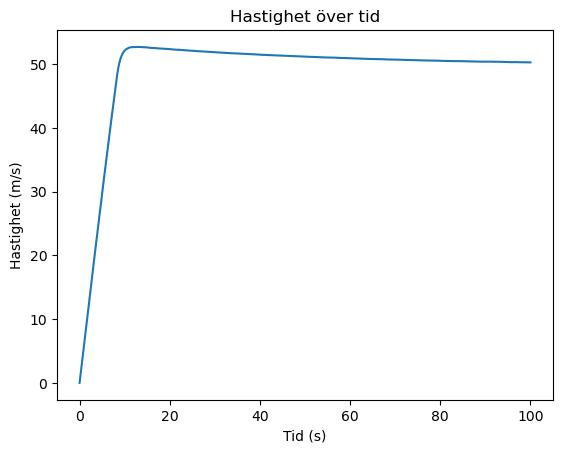

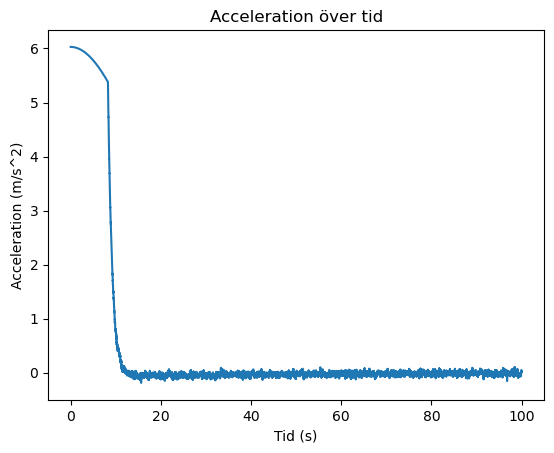

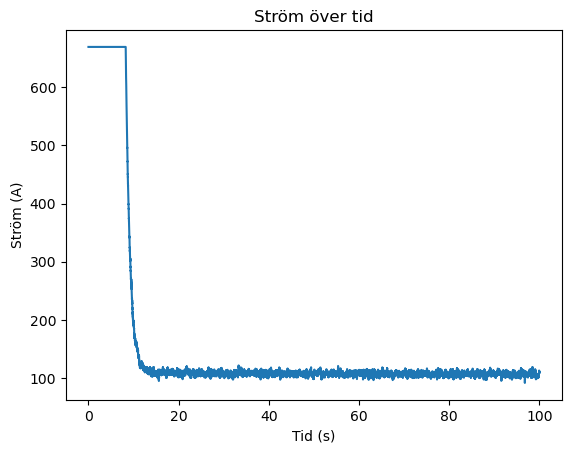

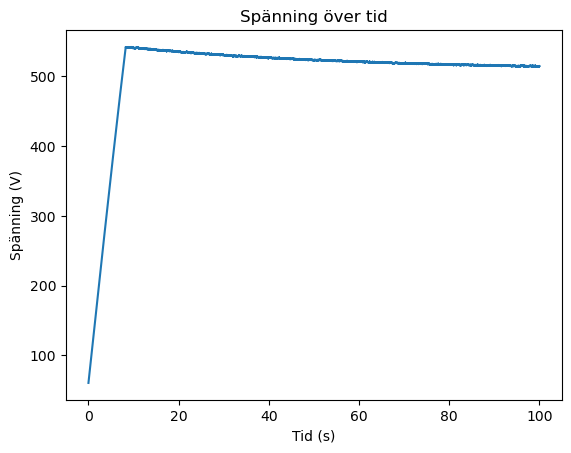

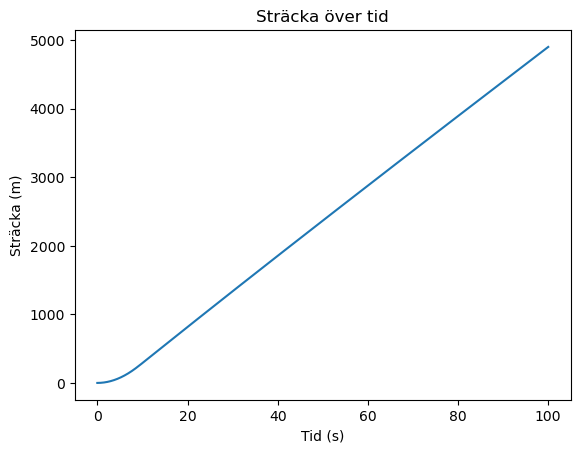

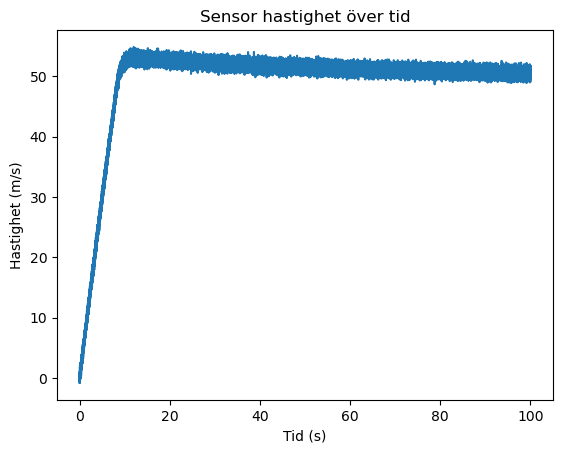

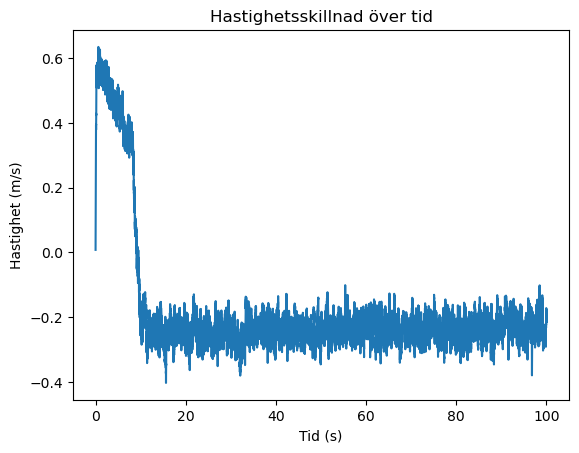

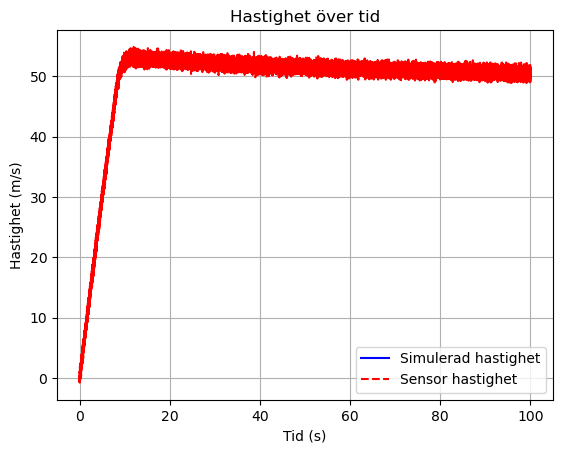

In [13]:
#=============================================================================
#-----------------------Simulering--------------------------------------------
#=============================================================================
#-----------------Simulering funktion-----------------------------------------
simtyp = 0                          # 0 = Strömstyrd, 1 = spänningsstyrd
m = 1040                            #(kg) massan
alpha = 0                           #(grader) lutningen i radianer (grader * pi/180)
U = 2679                            #(v)
I = 669                             #(A)
noise = 0.5                         #Standardavvikelse för brus i sensorn
mf = np.random.uniform(-0.02, 0.02) #Fel i mätning
fart = 50                           #(m/s) önskad hastighet
Reg_typ = 3                         #1 = P-regulator, 2 = PI-regulator, 3 = PID-regulator


def sim(m,alpha, U, I):             #simulerig med insignalerna m, alpha, U, I
    N = 100000                      #Antal iterrationer
    dt = 0.001                      #(s) Tidsteg (start fråm 1ms)
    Kp = 100                        #Proportionalitets konstant för regulatorn
    Ki = 2                          #Integralkonstant för regulatorn
    KD = 0.0                        #Derivata-konstant för regulatorn
    integral = 0                    #Integrerande term
    dervata = 0                     #Derivata term
    fel_start = 0                   #Antagande att fel från start är 0 
#------------------Skapar vektorer för att lagra in resultat---------------------
    t_vec = np.zeros(N)             #tid                    ex.[0,0,....,0]
    v_vec = np.zeros(N)             #hastighet              ex.[0,0,....,0]
    a_vec = np.zeros(N)             #acceleration           ex.[0,0,....,0]
    ia_vec = np.zeros(N)            #ankarstörm             ex.[0,0,....,0]
    U_vec = np.zeros(N)             #spänning               ex.[0,0,....,0]
    s_vec = np.zeros(N)             #sträcka                ex.[0,0,....,0]
    Sensor = np.zeros(N)            #Sensor mätvärden       ex.[0,0,....,0]
    Delta_V = np.zeros(N)           #Skillnad mellan verklig och uppmätt hastighet
    sensor_filter = np.zeros(N)     #Filterad sensordata (För att minska brus)

    for k in range(0,N):        #Från 0 till 999 (1000 iter.)

        t_vec[k]= k * dt                                #Sparar tiden för tillstånd k ex(0, 0.001, ...)
        #Mekaniska krafter från omvärden som verkar på fordonet
        F_aero_1 = F_aero(v_vec[k])                     #Räknar luftmotsåndet i tillstånd k för hastigheten i det tillståndet
        F_roll_1 = F_roll(alpha, m)                     #Räknar friktion i tillstånd k för hastigheten i det tillståndet
        F_grad_1 = F_grad(alpha, m)                     #Räknar lutning i tillstånd k för hastigheten i det tillståndet
        F_motstånd = F_aero_1 + F_roll_1 + F_grad_1     #Totala motståndet som verkar på fordonet
        #Mekaniska kraften vi får från motorn

#--------------------------Sensor-------------------------------------

        Sensor[k] = (1 + mf) * v_vec[k] + np.random.normal(0, noise)         #Förändringen i hastighet ? + felet i mätningen ? VARFÖR
        sensor_filter[k] = 0.01 * Sensor[k] + 0.99*sensor_filter[k-1]        #Tar 1 % av ny mätning och 99% av tidigare fliterat värde 
        Delta_V[k] = v_vec[k] - sensor_filter[k]                             #Skillnaden mellan verkliga hastighet och vad sensorn (Filterad) rapporterar. 
        
        fel = fart - sensor_filter[k]                                        #Varför ?
        
#----------------------Beräkna styrsignal-----------------------------
        if Reg_typ == 1:                                        # P-regulator
            I_reg = Kp * fel                                    #Ström prop. mot felet
            U_reg = Kp * fel                                    #Spännning prop. mot felet

        elif Reg_typ == 2:                                      # PI-regulator
            integral +=  fel * dt                               #Axkumulerar felet över tiden
            I_reg = Kp * fel + Ki * integral
            U_reg = Kp * fel + Ki * integral

        elif Reg_typ == 3:                                      # PID-regulator
            integral += + fel * dt
            if k == 0: 
                dervata = 0                                     #Första iterationen har inga tidigare data 
            else: 
                dervata = (fel-fel_start)/dt                    #Förändringshastighet av felet
            I_reg = Kp * fel + Ki * integral + KD * dervata
            U_reg = Kp * fel + Ki * integral + KD * dervata
            fel_start = fel                                     #Spara nuvarande fel för nästa iteration
            if I_reg > I:                                       #Begränsa regulatorns önskade ström (Undvicker höga värden)                                   #Begränsar strömen i regulatorn
                I_reg = I
            
#----------------------------------Styrning----------------------------            
        if simtyp==1:                                           #Fallet spänningstyrd

            ia_vec[k] = (U_reg - lamda * w_r(v_vec[k]))/Ra       
            if ia_vec[k] > I:                                   #Begränsar strömmen till max ström
                ia_vec[k] = I 
            U_vec[k] =  U_reg

        else:                                                   #Strömstyrd
            U_vec[k] = I_reg * Ra + lamda * w_r(v_vec[k])       #Sparar värden för späningen för varje tillstånd
            if U_vec[k] > U:                                    #Begränsar spänningen till max spänning
                U_vec[k] = U
            U_vec[k] = min(U_vec[k], U)
            ia_vec[k] = I_reg                                   #Sparar värden för strömmen för varje tillstånd

       
       
        T_hjul = n*(T_e(ia_vec[k])-T_f)/i                       #(Nm) Räknar hjulensvridmoment beroende av strömmen

        F_trac = T_hjul/r_hjul                                  #(N) Dragkraften vid hjulen

        F_net = F_trac - F_motstånd                             #(N) Nettokraften som får fordonet att röra sig

        a = F_net/m                                             #(m/s^2) Accelerationen

        if a > (mu * g * np.cos(alpha)):                        #Kollar om accelerationen är större än max acceleration
            a = mu * g * np.cos(alpha)                          #Sätter accelerationen till max acceleration
        a_vec[k] = a                                            #Sparar accelerationen i vektorn

        if k < (N - 1):
            v_vec[k+1] = v_vec[k] + (a * dt)                    #(Eulers-metod) Sparar hastigheten i nästa tillstånd
            #S = v * t + (a*t^2)/2
            s_vec[k+1] = s_vec[k] + (v_vec[k] * dt) + (a * (dt**2)) / 2 #Sparar sträckan i nästa tillstånd
   
#------------------------------------Plotar vektorerna -------------------------------
    #0 = ingen graf, 1 = fem separata, 2 = en sammanställd
    toggle = 1   #Ändra denna om du vill byta graf
    if toggle == 1:
        plt.plot(t_vec,v_vec)
        plt.title("Hastighet över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Hastighet (m/s)")
        plt.show()

        plt.plot(t_vec,a_vec)
        plt.title("Acceleration över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Acceleration (m/s^2)")
        plt.show()

        plt.plot(t_vec,ia_vec)
        plt.title("Ström över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Ström (A)")
        plt.show()
       
        plt.plot(t_vec,U_vec)
        plt.title("Spänning över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Spänning (V)")
        plt.show()

        plt.plot(t_vec,s_vec)
        plt.title("Sträcka över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Sträcka (m)")
        plt.show()

        plt.plot(t_vec,Sensor)
        plt.title("Sensor hastighet över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Hastighet (m/s)")
        plt.show()

        plt.plot(t_vec,Delta_V)
        plt.title("Hastighetsskillnad över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Hastighet (m/s)")
        plt.show()

        plt.plot(t_vec, v_vec, color='blue', label='Simulerad hastighet')
        plt.plot(t_vec, Sensor, color='red', linestyle='--', label='Sensor hastighet')
        plt.title("Hastighet över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Hastighet (m/s)")
        plt.legend()      # visar en förklarande ruta
        plt.grid(True)    # gör grafen lättare att läsa
        plt.show()
       

    #Om man vill ha allt i en graf:
    if toggle == 2:
        plt.plot(t_vec, v_vec, label="Hastighet")
        plt.plot(t_vec, a_vec, label="Acceleration")
        plt.plot(t_vec, ia_vec, label="Ström")
        plt.plot(t_vec, U_vec, label="Spänning")
        plt.plot(t_vec, s_vec, label="Sträcka")
        plt.title("Sammanställd graf")
        plt.xlabel("Tid (s)")
        plt.ylabel("Mätdata")
        plt.legend()
        plt.grid(True)
        plt.show()
sim(m, alpha, U, I)

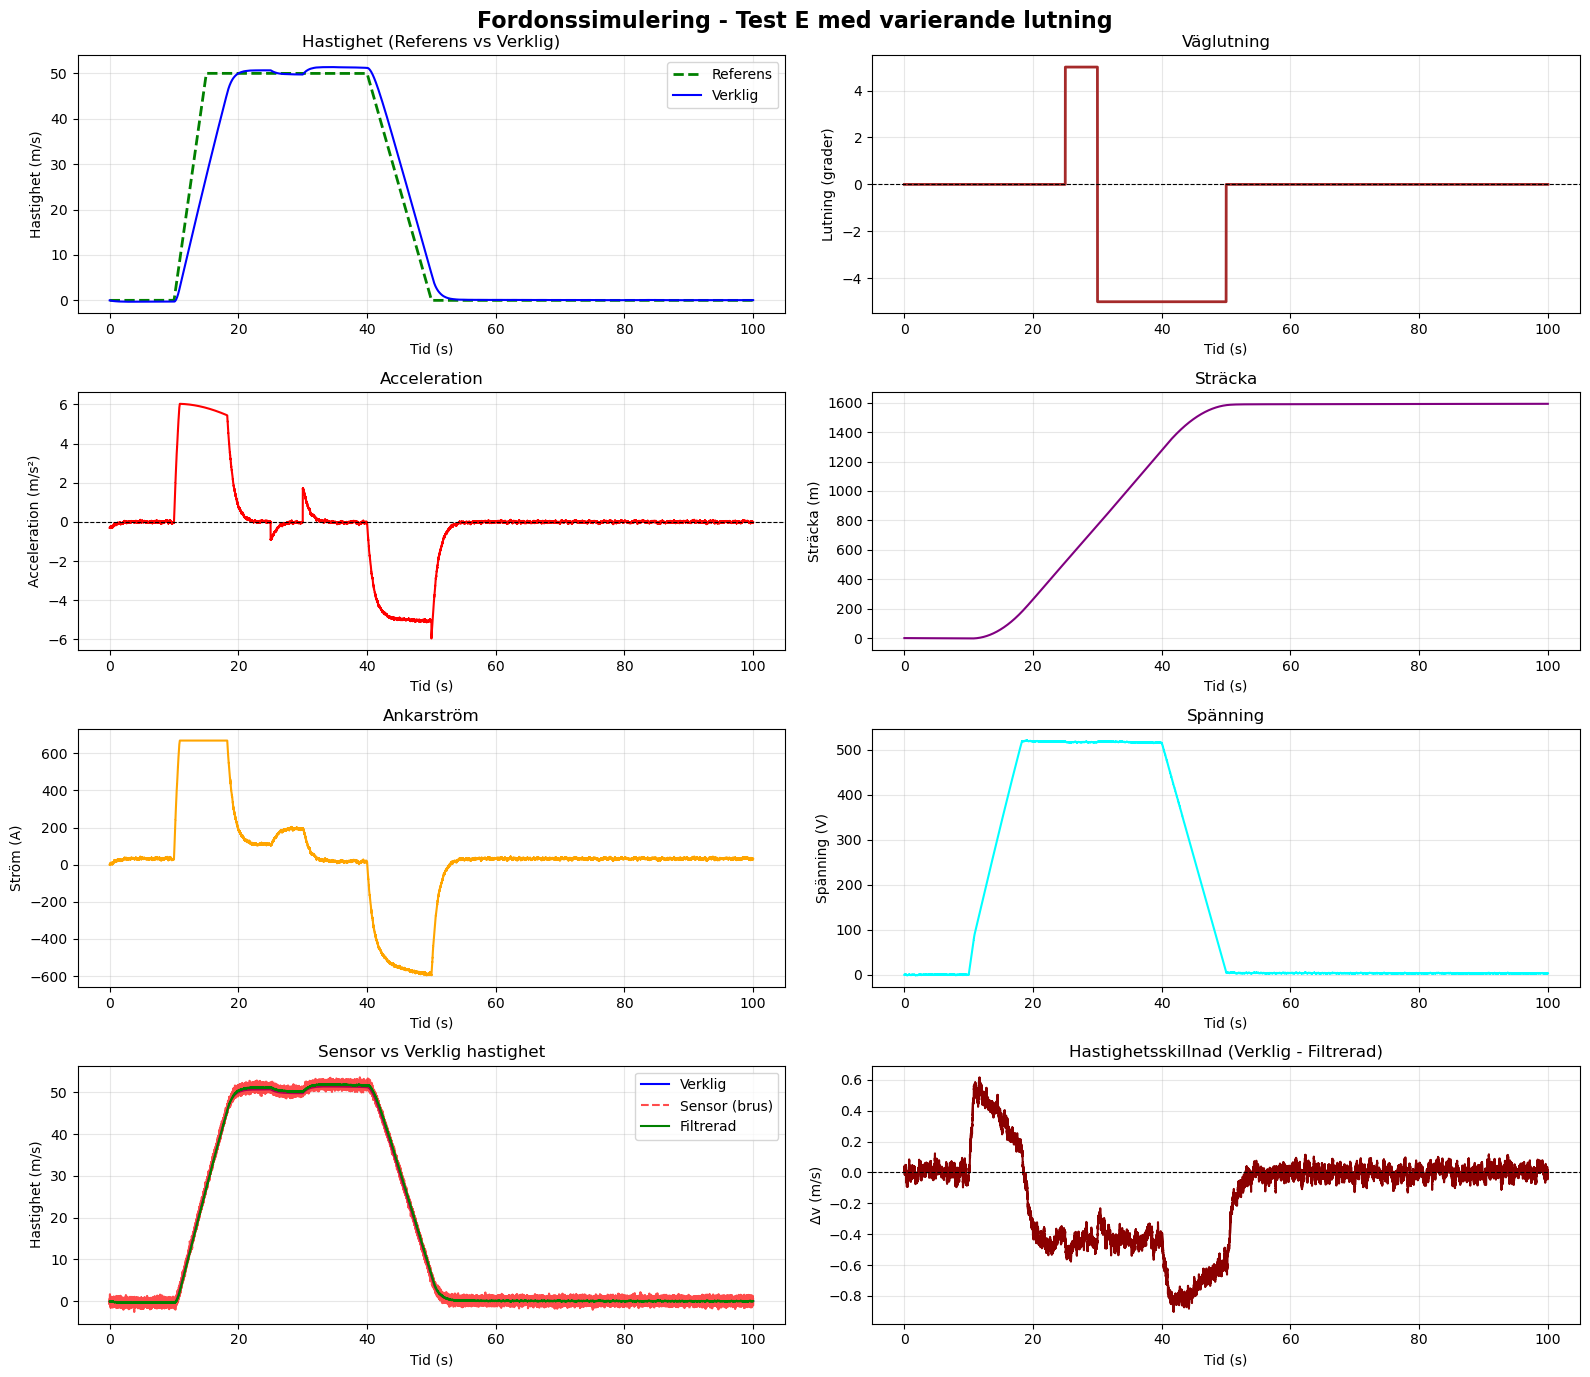

In [16]:
def refsignal_och_lutning (N, dt):
    N = 100000                              #Antal iterrationer
    dt = 0.001                              #Tidssteg 
    #------- skapar nya vektorer---------------
    t_vec_ref = np.arange(0,N*dt,dt)        #ref. tid                    ex.[0,0,....,0]
    v_ref = np.zeros(N)                     #ref. hastighet              ex.[0,0,....,0]
    alpha_vec = np.zeros(N)                 #Vägluningen                 ex.[0,0,....,0]
    #---------------------------------------------
    for k in range(N): 
        t = t_vec_ref[k] 
        if t < 10:                          #Fas 1: Stillastående (0 - 10)s
            v_ref[k] = 0
            alpha_vec[k] = 0
        elif t < 15:                        #Fas 2: Acceleration (10-15s) - accelerera till 50 m/s på 5s
            acceleration = 10               #(m/s^2) 
            v_ref[k] = acceleration * (t - 10)  #(m/s) Hastigheten 50 m/s
            alpha_vec[k] = 0                #luntingen 0
        elif t < 25:                        # Fas 3: Konstant fart horisontell väg (15-25s)
            v_ref[k] = 50
            alpha_vec[k] = 0
        elif t < 30:                        # Fas 4: Uppförsbacke 5 grader (25-30s)
            v_ref[k] = 50
            alpha_vec[k] = 5 * np.pi/180    #(grader) till radianer
        elif t < 40:                        # Fas 5: Nedförsbacke -5 grader (30-40s)
            v_ref[k] = 50
            alpha_vec[k] = -5 * np.pi/180   #(grader) till radianer
        elif t < 50:                        # Fas 6: Decelerering (40-50s)
            decceleration = -5              #(m/s^2)
            v_ref[k] = max(0, decceleration * (t - 40) + 50)
            alpha_vec[k] = -5 * np.pi/180   #(grader) till radianer
        else:
            v_ref[k] = 0
            alpha_vec[k] = 0
    
    return v_ref, alpha_vec
#=============================================================================
#-----------------------Simulering--------------------------------------------
#=============================================================================
#-----------------Simulering funktion-----------------------------------------
simtyp = 0                          #Variabel för att bestämma spänning- eller ström styrd
m = 1040                            #(kg) massan
alpha = 0                           #(grader) lutningen i radianer (grader * pi/180)
U = 2679                            #(v)
I = 669                             #(A)
noise = 0.5                         #Standardavvikelse för brus i sensorn
mf = np.random.uniform(-0.02, 0.02) #Fel i mätning
fart = 50                           #(m/s) önskad hastighet
Reg_typ = 3                         #1 = P-regulator, 2 = PI-regulator, 3 = PID-regulator
fel_start = 0                       #Antagande att fel från start är 0 

def sim(m, U, I, körtest_E=False):  #simulering med insignalerna m, U, I
    N = 100000                      #Antal iterrationer
    dt = 0.001                      #(s) Tidsteg (start fråm 1ms)
    
    #--------------------Skapa referenssignal och lutning för test E-------------------------------
    if körtest_E:                       
        v_ref_vec, alpha_vec = refsignal_och_lutning(N, dt)
    else:                               #Gäller från del D
        v_ref_vec = np.ones(N) * fart   #Konstant referenshastighet
        alpha_vec = np.ones(N) * alpha  #Konstant lutning
    #---------------------------------------------------------------------------------------------
    Kp = 100                        #Proportionalitets konstant för regulatorn
    Ki = 2                          #Integralkonstant för regulatorn
    KD = 0.0                        #Derivata-konstant för regulatorn
    integral = 0                    #Integrerande term
    dervata = 0                     #Derivata term
    #------------------Skapar vektorer för att lagra in resultat---------------------
    t_vec = np.zeros(N)             #tid                    ex.[0,0,....,0]
    v_vec = np.zeros(N)             #hastighet              ex.[0,0,....,0]
    a_vec = np.zeros(N)             #acceleration           ex.[0,0,....,0]
    ia_vec = np.zeros(N)            #ankarstörm             ex.[0,0,....,0]
    U_vec = np.zeros(N)             #spänning               ex.[0,0,....,0]
    s_vec = np.zeros(N)             #sträcka                ex.[0,0,....,0]
    Sensor = np.zeros(N)            #Sensor mätvärden       ex.[0,0,....,0]
    Delta_V = np.zeros(N)           #Skillnad mellan verklig och uppmätt hastighet
    sensor_filter = np.zeros(N)     #Sensor filtering för att minimera brus
    #------------------------------------------------------------------------------------
    for k in range(0,N):        #Från 0 till 999 (1000 iter.)

        t_vec[k]= k * dt                                #Sparar tiden för tillstånd k
        
        #Dynamisk lutning från alpha_vec
        alpha_k = alpha_vec[k]                          #Hämta lutning för detta tidssteg
        
        #Mekaniska krafter från omvärden som verkar på fordonet
        F_aero_1 = F_aero(v_vec[k])                     #Räknar luftmotsåndet i tillstånd k för hastigheten i det tillståndet
        F_roll_1 = F_roll(alpha_k, m)                   #Räknar friktion i tillstånd k för hastigheten i det tillståndet
        F_grad_1 = F_grad(alpha_k, m)                   #Räknar lutning i tillstånd k för hastigheten i det tillståndet
        F_motstånd = F_aero_1 + F_roll_1 + F_grad_1     #Totala motståndet som verkar på fordonet

    #--------------------------Sensor-------------------------------------

        Sensor[k] = (1 + mf) * v_vec[k] + np.random.normal(0, noise)         #Förändringen i hastighet ? + felet i mätningen ? VARFÖR
        sensor_filter[k] = 0.01 * Sensor[k] + 0.99*sensor_filter[k-1]        #Vi tar 1% av sensor, sen 99% av sensor filter 
        Delta_V[k] = v_vec[k] - sensor_filter[k]                             #Skillnaden i hastighet. 
        
        fel = v_ref_vec[k] - sensor_filter[k]                                #Beräkna fel mot referenshastighet
        fel_start = fel                                                      #Ersätt den tidigare fel med den nya
        
    #----------------------Beräkna styrsignal-----------------------------
        if Reg_typ == 1:       # P-regulator
            I_reg = Kp * fel
            U_reg = Kp * fel

        elif Reg_typ == 2:     # PI-regulator
            integral = integral + fel * dt
            I_reg = Kp * fel + Ki * integral
            U_reg = Kp * fel + Ki * integral

        elif Reg_typ == 3:     # PID-regulator
            integral = integral + fel * dt
            dervata = (fel-fel_start)/dt
            I_reg = Kp * fel + Ki * integral + KD * dervata
            if I_reg > I:      #Begränsar strömen i regulatorn
                I_reg = I
            U_reg = Kp * fel + Ki * integral + KD * dervata
            
            
    #----------------------------------Styrning----------------------------            
        if simtyp==1:                                            #Fallet spänningstyrd

            ia_vec[k] = (U_reg - lamda * w_r(v_vec[k]))/Ra       
            if ia_vec[k] > I:                                    #Begränsar strömmen till max ström
                ia_vec[k] = I 
            U_vec[k] =  U_reg

        else:                                               #Strömstyrd
            U_vec[k] = I_reg * Ra + lamda * w_r(v_vec[k])       #Sparar värden för späningen för varje tillstånd
            if U_vec[k] > U:                                #Begränsar spänningen till max spänning
                U_vec[k] = U
            U_vec[k] = min(U_vec[k], U)
            ia_vec[k] = I_reg                                    #Sparar värden för strömmen för varje tillstånd

       
       
        T_hjul = n*(T_e(ia_vec[k])-T_f)/i                   #(Nm) Räknar hjulensvridmoment beroende av strömmen

        F_trac = T_hjul/r_hjul                              #(N) Dragkraften vid hjulen

        F_net = F_trac - F_motstånd                         #(N) Nettokraften som får fordonet att röra sig

        a = F_net/m                                         #(m/s^2) Accelerationen

        # Använd dynamisk lutning för max acceleration
        if a > (mu * g * np.cos(alpha_k)):                  #Kollar om accelerationen är större än max acceleration
            a = mu * g * np.cos(alpha_k)                    #Sätter accelerationen till max acceleration
        a_vec[k] = a                                        #Sparar accelerationen i vektorn

        if k < (N - 1):
            v_vec[k+1] = v_vec[k] + (a * dt)                #(Eulers-metod) Sparar hastigheten i nästa tillstånd
            #S = v * t + (a*t^2)/2
            s_vec[k+1] = s_vec[k] + (v_vec[k] * dt) + (a * (dt**2)) / 2 #Sparar sträckan i nästa tillstånd
    #------------------------------------Plotar vektorerna -------------------------------
    #0 = ingen graf, 1 = separata fönster, 2 = subplots (rekommenderas!), 3 = allt i en graf
    toggle = 2   #Ändra denna om du vill byta plotstil
    
    if toggle == 1:
        # SEPARATA FÖNSTER - Varje graf i eget fönster
        plt.plot(t_vec,v_vec)
        plt.title("Hastighet över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Hastighet (m/s)")
        plt.grid(True)
        plt.show()

        plt.plot(t_vec,a_vec)
        plt.title("Acceleration över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Acceleration (m/s^2)")
        plt.grid(True)
        plt.show()

        plt.plot(t_vec,ia_vec)
        plt.title("Ström över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Ström (A)")
        plt.grid(True)
        plt.show()
       
        plt.plot(t_vec,U_vec)
        plt.title("Spänning över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Spänning (V)")
        plt.grid(True)
        plt.show()

        plt.plot(t_vec,s_vec)
        plt.title("Sträcka över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Sträcka (m)")
        plt.grid(True)
        plt.show()
        
        if körtest_E:
            plt.plot(t_vec, v_ref_vec, color='green', linestyle='--', label='Referenshastighet', linewidth=2)
            plt.plot(t_vec, v_vec, color='blue', label='Verklig hastighet')
            plt.title("Hastighet över tid - Test E")
            plt.xlabel("Tid (s)")
            plt.ylabel("Hastighet (m/s)")
            plt.legend()
            plt.grid(True)
            plt.show()
            
            plt.plot(t_vec, alpha_vec * 180/np.pi)
            plt.title("Väglutning över tid")
            plt.xlabel("Tid (s)")
            plt.ylabel("Lutning (grader)")
            plt.grid(True)
            plt.show()
    
    elif toggle == 2:
        # SUBPLOTS - Alla grafer i ett rutnät (REKOMMENDERAS!)
        if körtest_E:
            # För Test E: 4x2 rutnät (8 grafer)
            fig, axes = plt.subplots(4, 2, figsize=(16, 14))
            fig.suptitle('Fordonssimulering - Test E med varierande lutning', fontsize=16, fontweight='bold')
            
            # Rad 1, kolumn 1: Referenshastighet vs Verklig
            axes[0, 0].plot(t_vec, v_ref_vec, color='green', linestyle='--', label='Referens', linewidth=2)
            axes[0, 0].plot(t_vec, v_vec, color='blue', label='Verklig', linewidth=1.5)
            axes[0, 0].set_title('Hastighet (Referens vs Verklig)')
            axes[0, 0].set_xlabel('Tid (s)')
            axes[0, 0].set_ylabel('Hastighet (m/s)')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)
            
            # Rad 1, kolumn 2: Väglutning
            axes[0, 1].plot(t_vec, alpha_vec * 180/np.pi, color='brown', linewidth=2)
            axes[0, 1].set_title('Väglutning')
            axes[0, 1].set_xlabel('Tid (s)')
            axes[0, 1].set_ylabel('Lutning (grader)')
            axes[0, 1].grid(True, alpha=0.3)
            axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
            
            # Rad 2, kolumn 1: Acceleration
            axes[1, 0].plot(t_vec, a_vec, color='red', linewidth=1.5)
            axes[1, 0].set_title('Acceleration')
            axes[1, 0].set_xlabel('Tid (s)')
            axes[1, 0].set_ylabel('Acceleration (m/s²)')
            axes[1, 0].grid(True, alpha=0.3)
            axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
            
            # Rad 2, kolumn 2: Sträcka
            axes[1, 1].plot(t_vec, s_vec, color='purple', linewidth=1.5)
            axes[1, 1].set_title('Sträcka')
            axes[1, 1].set_xlabel('Tid (s)')
            axes[1, 1].set_ylabel('Sträcka (m)')
            axes[1, 1].grid(True, alpha=0.3)
            
            # Rad 3, kolumn 1: Ström
            axes[2, 0].plot(t_vec, ia_vec, color='orange', linewidth=1.5)
            axes[2, 0].set_title('Ankarström')
            axes[2, 0].set_xlabel('Tid (s)')
            axes[2, 0].set_ylabel('Ström (A)')
            axes[2, 0].grid(True, alpha=0.3)
            
            # Rad 3, kolumn 2: Spänning
            axes[2, 1].plot(t_vec, U_vec, color='cyan', linewidth=1.5)
            axes[2, 1].set_title('Spänning')
            axes[2, 1].set_xlabel('Tid (s)')
            axes[2, 1].set_ylabel('Spänning (V)')
            axes[2, 1].grid(True, alpha=0.3)
            
            # Rad 4, kolumn 1: Sensor vs Verklig hastighet
            axes[3, 0].plot(t_vec, v_vec, color='blue', label='Verklig', linewidth=1.5)
            axes[3, 0].plot(t_vec, Sensor, color='red', linestyle='--', alpha=0.7, label='Sensor (brus)')
            axes[3, 0].plot(t_vec, sensor_filter, color='green', linewidth=1.5, label='Filtrerad')
            axes[3, 0].set_title('Sensor vs Verklig hastighet')
            axes[3, 0].set_xlabel('Tid (s)')
            axes[3, 0].set_ylabel('Hastighet (m/s)')
            axes[3, 0].legend()
            axes[3, 0].grid(True, alpha=0.3)
            
            # Rad 4, kolumn 2: Hastighetsskillnad (fel)
            axes[3, 1].plot(t_vec, Delta_V, color='darkred', linewidth=1.5)
            axes[3, 1].set_title('Hastighetsskillnad (Verklig - Filtrerad)')
            axes[3, 1].set_xlabel('Tid (s)')
            axes[3, 1].set_ylabel('Δv (m/s)')
            axes[3, 1].grid(True, alpha=0.3)
            axes[3, 1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
            
        else:
            # För vanlig simulering: 3x2 rutnät (6 grafer)
            fig, axes = plt.subplots(3, 2, figsize=(16, 10))
            fig.suptitle('Fordonssimulering - Standardläge', fontsize=16, fontweight='bold')
            
            # Hastighet
            axes[0, 0].plot(t_vec, v_vec, color='blue', linewidth=1.5)
            axes[0, 0].set_title('Hastighet')
            axes[0, 0].set_xlabel('Tid (s)')
            axes[0, 0].set_ylabel('Hastighet (m/s)')
            axes[0, 0].grid(True, alpha=0.3)
            
            # Acceleration
            axes[0, 1].plot(t_vec, a_vec, color='red', linewidth=1.5)
            axes[0, 1].set_title('Acceleration')
            axes[0, 1].set_xlabel('Tid (s)')
            axes[0, 1].set_ylabel('Acceleration (m/s²)')
            axes[0, 1].grid(True, alpha=0.3)
            
            # Ström
            axes[1, 0].plot(t_vec, ia_vec, color='orange', linewidth=1.5)
            axes[1, 0].set_title('Ankarström')
            axes[1, 0].set_xlabel('Tid (s)')
            axes[1, 0].set_ylabel('Ström (A)')
            axes[1, 0].grid(True, alpha=0.3)
            
            # Spänning
            axes[1, 1].plot(t_vec, U_vec, color='cyan', linewidth=1.5)
            axes[1, 1].set_title('Spänning')
            axes[1, 1].set_xlabel('Tid (s)')
            axes[1, 1].set_ylabel('Spänning (V)')
            axes[1, 1].grid(True, alpha=0.3)
            
            # Sträcka
            axes[2, 0].plot(t_vec, s_vec, color='purple', linewidth=1.5)
            axes[2, 0].set_title('Sträcka')
            axes[2, 0].set_xlabel('Tid (s)')
            axes[2, 0].set_ylabel('Sträcka (m)')
            axes[2, 0].grid(True, alpha=0.3)
            
            # Sensor
            axes[2, 1].plot(t_vec, v_vec, color='blue', label='Verklig', linewidth=1.5)
            axes[2, 1].plot(t_vec, Sensor, color='red', linestyle='--', alpha=0.7, label='Sensor')
            axes[2, 1].set_title('Hastighet (Verklig vs Sensor)')
            axes[2, 1].set_xlabel('Tid (s)')
            axes[2, 1].set_ylabel('Hastighet (m/s)')
            axes[2, 1].legend()
            axes[2, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    elif toggle == 3:
        # ALLT I EN GRAF - Alla kurvor överlagrade (inte rekommenderat)
        plt.figure(figsize=(14, 8))
        plt.plot(t_vec, v_vec, label="Hastighet (m/s)", linewidth=2)
        plt.plot(t_vec, a_vec, label="Acceleration (m/s²)", linewidth=2)
        plt.plot(t_vec, ia_vec/100, label="Ström (A/100)", linewidth=2)
        plt.plot(t_vec, U_vec/1000, label="Spänning (kV)", linewidth=2)
        plt.plot(t_vec, s_vec/100, label="Sträcka (100m)", linewidth=2)
        if körtest_E:
            plt.plot(t_vec, alpha_vec * 180/np.pi * 10, label="Lutning (10×grader)", linewidth=2)
        plt.title("Sammanställd graf - Alla parametrar", fontsize=14, fontweight='bold')
        plt.xlabel("Tid (s)")
        plt.ylabel("Skalerade värden")
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        plt.show()

sim(m, U, I, körtest_E=True)